In [5]:
%load_ext autoreload
%autoreload 2
from keras.applications.vgg16 import VGG16

import numpy as np
import os
import pandas as pd
from sklearn.metrics import accuracy_score

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import models.simpleConv as simpleConv
import models.betterConv as betterConv
from imgaug import augmenters as iaa

import h5py
from imgaug import augmenters as iaa
from keras.utils import np_utils

import utils
import preprocessing as pp
pp.init()

allTrainingFolders = [x for x in os.listdir(pp.trainPath) if x.startswith('n')]
trainingFolders = allTrainingFolders[0:5]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Checking to make sure output directories are created..
..done


# Parsing & Data Loading & Model Fitting

In [6]:
encoder = LabelBinarizer()
##MAKE SURE classLabels is set to ALL the folders you will train on, even if doing in batches
encoder = encoder.fit(trainingFolders) 

parse = False
train = True
saveModel = False
includeAugmented = False
onlyAugmented = False

augments = [iaa.GaussianBlur(3.0)]
h5filename = 'VGGwith224NORM.h5'

if parse:
    if os.path.isfile(os.path.join(pp.h5Path, h5filename)):
        os.remove(os.path.join(pp.h5Path, h5filename))
    pp.parseImages(trainingFolders, h5filename)
    
#NOTE: KEEP BATCH SIZE = # of all folders for now because we need to shuffle H5. 


callbacks = []
epochs = 3

print(pp.img_width)
print(pp.img_height)

# vggConv = VGG16(weights=None, include_top ='True', classes=5)
# model = vggConv.build_model(len(encoder.classes_), pp.img_width, pp.img_height, 3)

model = VGG16(weights=None, include_top ='True', classes=5)

# model = betterConv.build_model(len(encoder.classes_), pp.img_width, pp.img_height, 3)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

all_x_val = []
all_y_val = []
all_x_train = []
all_y_train = []

# x_train, y_train, x_val, y_val = pp.loadH5(h5filename)


f = h5py.File(os.path.join(pp.h5Path, h5filename), 'r')
train_x = f['x_train']
train_y = f['y_train']
val_x = f['x_val']
val_y = f['y_val']

batch_size = 50

# print("x_train: ", train_x)
# scaler = StandardScaler().fit(train_x) 
# rescaledX = scaler.transform(train_x)
# print("Rescaled: ", rescaledX)

##FIT MODEL
if train:
    for epoch in range(0, epochs):
        print("Epoch Number: ", epoch)
        idxs = np.random.permutation(len(train_x))
        batches = utils.chunks(idxs, batch_size)
        batches_sorted = [np.sort(b) for b in batches]

        print("training for {0} batches".format(len(batches_sorted)))
        batch_num = 0
        for batch in batches_sorted:
            batch_num +=1

            x_train = train_x[list(batch)]
            y_train = train_y[list(batch)]
            y_train = [y.decode('utf-8') for y in y_train]



            x_aug = []
            y_aug = []
            if includeAugmented:
                x_aug, y_aug = pp.augmentData(x_train, y_train, augments = augments)
                if onlyAugmented:
                    x_train = x_aug
                    y_train = y_aug
                else:
                    x_train.extend(x_aug)
                    y_train.extend(y_aug)

            y_train = encoder.transform(y_train) #call encoder.inverse_transform() to get real class labels



    #         model.train_on_batch(np.array(x_train), np.array(y_train))
    #         results = model.fit(np.array(x_train), np.array(y_train), 
    #                     validation_data = (np.array(x_val), np.array(y_val)),
    #                     epochs=epochs, verbose=1, callbacks = callbacks)

            results = model.fit(np.array(x_train), np.array(y_train),
                epochs=1, callbacks = callbacks, )

        if saveModel:
            count = 1
            outputName = ""
            while True:
                k = ''
                if includeAugmented:
                    k = 'with-aug'
                if onlyAugmented:
                    k = 'aug-only'
                s = pp.baseModelName.format(epoch, count, k) + ".h5" 
                if not s in os.listdir(pp.outputModelPath):         
                    outputName = s         
                    break     
                else:         
                    count+=1 
            print(outputName)
            model.save(os.path.join(pp.outputModelPath, outputName))


224
224
Epoch Number:  0
training for 42 batches
Epoch 1/1


ResourceExhaustedError: OOM when allocating tensor with shape[32,128,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: block2_conv2/convolution = Conv2D[T=DT_FLOAT, _class=["loc:@train...kpropInput"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](block2_conv1/Relu, block2_conv2/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: training_1/Adam/gradients/AddN/_487 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_557_training_1/Adam/gradients/AddN", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [85]:
print(model)

In [2]:
encoder = LabelBinarizer()
##MAKE SURE classLabels is set to ALL the folders you will train on, even if doing in batches
encoder = encoder.fit(trainingFolders) 

parse = False
train = True
saveModel = False
includeAugmented = False
onlyAugmented = False

augments = [iaa.GaussianBlur(3.0)]
h5filename = 'VGGwith224NORM.h5'

if parse:
    if os.path.isfile(os.path.join(pp.h5Path, h5filename)):
        os.remove(os.path.join(pp.h5Path, h5filename))
    pp.parseImages(trainingFolders, h5filename)
    
#NOTE: KEEP BATCH SIZE = # of all folders for now because we need to shuffle H5. 


callbacks = []
epochs = 20

print(pp.img_width)
print(pp.img_height)

model = betterConv.build_model(len(encoder.classes_), pp.img_width, pp.img_height, 3)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

all_x_val = []
all_y_val = []
all_x_train = []
all_y_train = []

# x_train, y_train, x_val, y_val = pp.loadH5(h5filename)


f = h5py.File(os.path.join(pp.h5Path, h5filename), 'r')
train_x = f['x_train']
train_y = f['y_train']
val_x = f['x_val']
val_y = f['y_val']

batch_size = 50



##FIT MODEL
if train:
    for epoch in range(0, epochs):
        print("Epoch Number: ", epoch)
        idxs = np.random.permutation(len(train_x))
        batches = utils.chunks(idxs, batch_size)
        batches_sorted = [np.sort(b) for b in batches]

        print("training for {0} batches".format(len(batches_sorted)))
        batch_num = 0
        for batch in batches_sorted:
            batch_num +=1

            x_train = train_x[list(batch)]
            y_train = train_y[list(batch)]
            y_train = [y.decode('utf-8') for y in y_train]



            x_aug = []
            y_aug = []
            if includeAugmented:
                x_aug, y_aug = pp.augmentData(x_train, y_train, augments = augments)
                if onlyAugmented:
                    x_train = x_aug
                    y_train = y_aug
                else:
                    x_train.extend(x_aug)
                    y_train.extend(y_aug)

            y_train = encoder.transform(y_train) #call encoder.inverse_transform() to get real class labels



    #         model.train_on_batch(np.array(x_train), np.array(y_train))
    #         results = model.fit(np.array(x_train), np.array(y_train), 
    #                     validation_data = (np.array(x_val), np.array(y_val)),
    #                     epochs=epochs, verbose=1, callbacks = callbacks)

            results = model.fit(np.array(x_train), np.array(y_train),
                epochs=1, callbacks = callbacks, )

        if saveModel:
            count = 1
            outputName = ""
            while True:
                k = ''
                if includeAugmented:
                    k = 'with-aug'
                if onlyAugmented:
                    k = 'aug-only'
                s = pp.baseModelName.format(epoch, count, k) + ".h5" 
                if not s in os.listdir(pp.outputModelPath):         
                    outputName = s         
                    break     
                else:         
                    count+=1 
            print(outputName)
            model.save(os.path.join(pp.outputModelPath, outputName))

224
224
Poop:  (224, 224, 3)
Epoch Number:  0
training for 42 batches
Epoch 1/1
50/50 [==============================] - 3s 65ms/step - loss: 1.6311 - acc: 0.2000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6839 - acc: 0.2000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.6034 - acc: 0.1800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3069 - acc: 0.4800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9258 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1441 - acc: 0.5800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.1852 - acc: 0.5000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8890 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.4960 - acc: 0.4600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.3769 - acc: 0.4200
Epoch 1/1

50/50 [==============================] - 0s 2ms/step - loss: 0.9596 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0031 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7986 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8040 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0225 - acc: 0.5600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7840 - acc: 0.5800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0094 - acc: 0.5000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8492 - acc: 0.6600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0352 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6654 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0677 - acc: 0.520

50/50 [==============================] - 0s 2ms/step - loss: 0.9231 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7648 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7984 - acc: 0.5400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.9013 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8033 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5494 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7170 - acc: 0.6200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7204 - acc: 0.6400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6421 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7089 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5514 - acc: 0.640

50/50 [==============================] - 0s 2ms/step - loss: 0.6191 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.7162 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6127 - acc: 0.6800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.8511 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5479 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5447 - acc: 0.7800
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5424 - acc: 0.7000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 1.0281 - acc: 0.6000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5735 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5623 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6330 - acc: 0.700

50/50 [==============================] - 0s 2ms/step - loss: 0.8895 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5681 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6082 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4234 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.6505 - acc: 0.7200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5072 - acc: 0.8000
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5224 - acc: 0.7400
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5071 - acc: 0.7600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4130 - acc: 0.8600
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.4586 - acc: 0.8200
Epoch 1/1
50/50 [==============================] - 0s 2ms/step - loss: 0.5953 - acc: 0.760

KeyboardInterrupt: 

In [39]:
encoder.inverse_transform(y_train)

array(['n01440764', 'n01440764', 'n01440764', 'n01440764', 'n01440764'],
      dtype='<U9')

In [38]:
y_train

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [3]:
x_val = val_x[:]
y_val = val_y[:]
y_val = [y.decode('utf-8') for y in y_val]
y_val = encoder.fit_transform(y_val)

val_scores = model.evaluate(np.array(x_val), np.array(y_val))
# train_scores = model.evaluate(np.array(all_x_train), np.array(all_y_train))

519/519 [==============================] - 1s 1ms/step


In [9]:
print(model.metrics_names)
print("val: {0}".format(val_scores))
print("train: {0}".format(train_scores))
#224 NORMALIZED

['loss', 'acc']
val: [0.8909650876802286, 0.5549132947976878]


NameError: name 'train_scores' is not defined

In [8]:
print(model.metrics_names)
print("val: {0}".format(val_scores))
print("train: {0}".format(train_scores))
#224 STANDARDIZED

['loss', 'acc']
val: [1.1374628640323705, 0.5163776493830488]


NameError: name 'train_scores' is not defined

In [4]:
print(model.metrics_names)
print("val: {0}".format(val_scores))
print("train: {0}".format(train_scores))
#448 NORMALIZED

['loss', 'acc']
val: [0.8695772805884624, 0.5973025049892234]


NameError: name 'train_scores' is not defined

In [4]:
print(model.metrics_names)
print("val: {0}".format(val_scores))
print("train: {0}".format(train_scores))
#448 STANDARDIZED

['loss', 'acc']
val: [1.2172713180957273, 0.49518304448826006]


NameError: name 'train_scores' is not defined

In [4]:
print(model.metrics_names)
print("val: {0}".format(val_scores))
print("train: {0}".format(train_scores))


['loss', 'acc']
val: [0.8891585647255928, 0.6589595377445221]


NameError: name 'train_scores' is not defined

# MODEL: BUILDING + TRAINING

6500

# EVALUATION

In [73]:
predictions = model.predict(np.array(x_val))

[('hammerhead, hammerhead shark', 0.45316857), ('stingray', 0.31493774), ('tiger shark, Galeocerdo cuvieri', 0.2102153)]


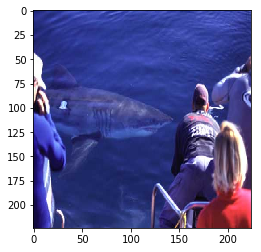

In [74]:
k = 301

pp.displayImage(x_val[k])
#PRINT PREDICTION CLASSES
print(pp.topClasses(predictions[k], encoder.classes_))

#LOAD PREDICTIONS INTO DATAFRAME, compute accuracy
def predictionsToDataframe(predictions, truth, encoder):
    one = []
    two = []
    three = []
    for p in predictions:
        top = pp.topClasses(p, encoder.classes_)
        one.append(top[0][0])
        two.append(top[1][0])
        three.append(top[2][0])
        
    df = pd.DataFrame({'truth': [pp.translateID(x) for x in encoder.inverse_transform(truth)],
                      'one': one,
                      'two': two,
                      'three': three}) 

    return df

df = predictionsToDataframe(predictions, y_val, encoder)

In [80]:
acc = len(df[df.truth == df.one])/len(df)
print("Top-1 accuracy: {0}".format(acc))

acc = len(df[(df.truth == df.one) | (df.truth == df.two)])/len(df)
print("Top-2 accuracy: {0}".format(acc))

acc = len(df[(df.truth == df.one) | (df.truth == df.two) | (df.truth == df.three) ]) / len(df)
print("Top-3 accuracy: {0}".format(acc))

# df.iloc[504]

Top-1 accuracy: 0.24957199923910975
Top-2 accuracy: 0.3608521970705726
Top-3 accuracy: 0.42914209625261557


Steps
1. Parse Image Data for all folders that you want to train on
2. Load in each batch and repeat:
    3. Apply augments to batch, if any
    4. Train batch
5. Evaluate model. 

# BATCH SELECTION

In [305]:
f = h5py.File(os.path.join(pp.h5Path, h5filename), 'r')
train_x = f['x_train']
train_y = f['y_train']
batch_size = 50

idxs = np.random.permutation(len(train_x))
batches = utils.chunks(idxs, batch_size)
batches_sorted = [np.sort(b) for b in batches]



In [315]:
x = train_x[list(batches_sorted[0])]
y = train_y[list(batches_sorted[0])]

goldfish, Carassius auratus


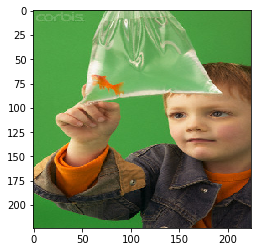

In [318]:
pp.displayImage(x[1])
print(pp.translateID(y[1].decode('utf-8')))

In [317]:
y

array([b'n01443537', b'n01443537', b'n01443537', b'n01443537',
       b'n01443537', b'n01443537', b'n01443537', b'n01443537',
       b'n01443537', b'n01443537', b'n01443537', b'n01443537',
       b'n01491361', b'n01491361', b'n01491361', b'n01491361',
       b'n01491361', b'n01491361', b'n01491361', b'n01491361',
       b'n01491361', b'n01494475', b'n01494475', b'n01494475',
       b'n01494475', b'n01494475', b'n01494475', b'n01494475',
       b'n01494475', b'n01494475', b'n01494475', b'n01494475',
       b'n01494475', b'n01494475', b'n01440764', b'n01440764',
       b'n01440764', b'n01440764', b'n01440764', b'n01440764',
       b'n01440764', b'n01440764', b'n01440764', b'n01484850',
       b'n01484850', b'n01484850', b'n01484850', b'n01484850',
       b'n01484850', b'n01484850'], dtype='|S9')

In [ ]:
class DataGenerator():
    
    def __init__

# Graphs

In [78]:
results.history

{'loss': [0.5523953437805176], 'acc': [0.875]}

In [100]:
outputPath = os.path.join('output','saved-models')

modelsFrom100 = []
val_scores = []

modelsFrom100.append(os.path.join(outputPath, "model-0-7-.h5"))
modelsFrom100.append(os.path.join(outputPath, "model-1-6-.h5"))
modelsFrom100.append(os.path.join(outputPath, "model-2-1-.h5"))
modelsFrom100.append(os.path.join(outputPath, "model-3-1-.h5"))
modelsFrom100.append(os.path.join(outputPath, "model-4-1-.h5"))
modelsFrom100.append(os.path.join(outputPath, "model-5-1-.h5"))
modelsFrom100.append(os.path.join(outputPath, "model-6-1-.h5"))
modelsFrom100.append(os.path.join(outputPath, "model-7-1-.h5"))
modelsFrom100.append(os.path.join(outputPath, "model-8-1-.h5"))
modelsFrom100.append(os.path.join(outputPath, "model-9-1-.h5"))

# x_val = val_x[:]
# y_val = val_y[:]
# y_val = [y.decode('utf-8') for y in y_val]
# y_val = encoder.fit_transform(y_val)

# val_scores = model1.evaluate(np.array(x_val), np.array(y_val))
for modelName in modelsFrom100:
    model = load_model(modelName)
    val_scores.append(model.evaluate(np.array(x_val), np.array(y_val)))
    
val_scores
# print(model1)
# print(model1loaded)

10514/10514 [==============================] - 14s 1ms/step


[[3.4991698467348247, 0.16283051169868745],
 [3.08843700899832, 0.23949020354664324],
 [2.918062787875037, 0.28143427810609195],
 [2.915889410412944, 0.29037473845248307],
 [3.0873023972938514, 0.28742628875926396],
 [3.4732818409406527, 0.2758227125751285],
 [3.827974426943652, 0.2684991439998955],
 [4.3541993239498735, 0.2660262507147519],
 [4.835062457645758, 0.26127068671194664],
 [5.257831900387815, 0.24957199924761336]]

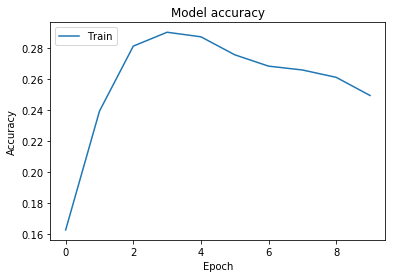

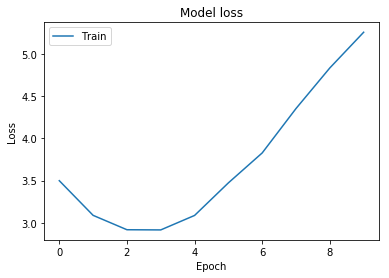

In [101]:
val_scores_acc = []
val_scores_loss = []
for i in val_scores:
    val_scores_acc.append(i[1])
    val_scores_loss.append(i[0])

# Plot training & validation accuracy values
plt.plot(val_scores_acc)
# plt.plot(results.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
# plt.ylim(0.5, 1.0)
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(val_scores_loss)
# plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
# plt.ylim(0, 0.7)
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()